Universidade Estadual de Campinas (UNICAMP), Instituto de Computação (IC)

Prof. Jacques Wainer, 2021s1

In [ ]:
# RA & Name
print('264965: ' + 'Décio Luiz Gazzoni Filho')
print('265673: ' + 'Gabriel Luciano Gomes')
print('192880: ' + 'Lucas Borges Rondon')

264965: Décio Luiz Gazzoni Filho
265673: Gabriel Luciano Gomes
192880: Lucas Borges Rondon


In [1]:
!pip install --upgrade numpy scikit-learn pmdarima

     |████████████████████████████████| 15.7MB 180kB/s 
     |████████████████████████████████| 22.3MB 60.3MB/s 
     |████████████████████████████████| 1.5MB 24.6MB/s 
     |████████████████████████████████| 9.5MB 17.2MB/s 
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.21.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: pmdarima 1.8.2 has requirement numpy~=1.19.0, but you'll have numpy 1.21.0 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: statsmodels 0.10.2
    Unin

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Leitura da base de dados

In [1]:
import pandas as pd
import requests
import io

url = "https://www.ic.unicamp.br/~wainer/cursos/1s2021/432/ouro2.csv"
s = requests.get(url).content

db = pd.read_csv(io.StringIO(s.decode('utf-8')))
db = db[::-1].reset_index(drop=True)
db.head()

,Data,Valor
0,18/06/2000,282.7
1,25/06/2000,290.1
2,02/07/2000,283.2
3,09/07/2000,281.1
4,16/07/2000,280.1


# Pré-processamento dos dados

## Remoção da coluna "Data"

In [2]:
db = db.drop(columns=['Data'])

db.head()

,Valor
0,282.7
1,290.1
2,283.2
3,281.1
4,280.1


## Separação da base de dados em treino e teste

In [3]:
x_train = db[:996].to_numpy().flatten()
x_test = db[996:].to_numpy().flatten()

# Funções auxiliares

In [4]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from statistics import mean
from hyperopt import hp, tpe, fmin, STATUS_OK
import pmdarima as pm

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ConvergenceWarning as SMConvergenceWarning
import warnings
from math import log

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', SMConvergenceWarning)

def get_y_classification(data):
  y = [1]
  for i in range(1, len(data)):
     y.append(1 if data[i] > data[i-1] else 0)
  return np.array(y)

def slide_window(input, output, init_idx, set_size, window_size):
  x = sliding_window_view(input[init_idx:init_idx+set_size+window_size-1],
                          window_shape = window_size)
  y = output[init_idx + window_size : init_idx + set_size + window_size]
  
  return x, y

def test_model_accuracy(model, data, split, window_size):
  
  y = get_y_classification(data)

  s_window_x, s_window_y  = slide_window(data, y, 0, len(data) - window_size, window_size)  

  return (mean(cross_val_score(model, s_window_x, s_window_y, cv=split,
                      scoring='accuracy')))

def test_model_rmse(model, data, split, window_size):
  s_window_x, s_window_y  = slide_window(data, data, 0, len(data) - window_size, window_size)

  return (mean(cross_val_score(model, s_window_x, s_window_y, cv=split,
                      scoring='neg_root_mean_squared_error')))

def hyperopt_train_test(params): 
    # global data
    config = params['config']
    model = config['model']    
    split = config['split']
    score_func = config['score_func']
    data = config['data']()
    del params['config']

    model_params = params['model_params']
    del params['model_params']

    window_size = params['window_size']
    del params['window_size']

    temp = {**params, **model_params}

    clf = model(**temp)

    return score_func(clf, data, split, window_size)

def objective_function_bo(params):
  acc = hyperopt_train_test(params)  
  return {'loss': -acc, 'status': STATUS_OK}

def best_results(config, choice_vars, space, model_params, scoring, window_size,  n_iter = 10):
  model_params_with_choice_vars = model_params.copy()
  for key in choice_vars:
    model_params_with_choice_vars[key] = hp.choice(key, choice_vars[key])

  params = {'config': config, 'model_params': model_params_with_choice_vars,
            **space, 'window_size': hp.choice('window_size', window_size)}

  hparams = fmin(objective_function_bo, params, algo = tpe.suggest,
                 max_evals = n_iter)  

  # config values
  model = config['model']
  data  = config['data']()
  split = config['split']
  best_w_size = window_size[hparams['window_size']]
  score_func = config['score_func']

  for key in hparams:
    if key in choice_vars:
      hparams[key] = choice_vars[key][hparams[key]]

  del hparams['window_size']

  # best score calc
  best_result  = score_func(model(**{**hparams, **model_params}),
                            data, split, best_w_size)
  
  model_default =  score_func(model(**model_params), data, split, best_w_size)

  if (scoring == 'RMSE'):
    best_result = -best_result
    model_default = -model_default

  string_result = f'Melhor {scoring}: {best_result:5f} para'

  for key in hparams:
    string_result += f' {key}: {hparams[key]:5f} \t'

  string_result += f'Window size: {best_w_size}'

  print(string_result)

  print(f'{scoring} para modelo default: {model_default:5f}')

  hparams['window_size'] = best_w_size

  return (hparams, best_result, model_default)


def find_best_model(models, score):  
  models_scoring = []
  best_score   = float('inf')
  best_params  = None
  best_model   = None

  for model in models:
    config = model['config']
    choice_vars = model['choice_vars']
    space =  model['space']
    model_params = model['model_params']
    n_iter = model['n_iter']
    print('*' *20 + ' ' + model['name'] + ' ' + '*' *20)
    print(f'model_params = {model_params}')
    hparams, best_result, result_default = best_results(config, choice_vars,
                                                        space, model_params,
                                                        score,
                                                        window_size = range(1, 9),
                                                        n_iter = n_iter)

    models_scoring.append({'name': model['name'], 'params': hparams,
                           'score': best_result, 'default': False})
    models_scoring.append({'name': model['name'], 'params': None,
                           'score': result_default, 'default': True})

  if score == 'accuracy':
    models_scoring = sorted(models_scoring, key=lambda k: k['score'],
                            reverse=True) 
  else:
    models_scoring = sorted(models_scoring, key=lambda k: k['score']) 

  print('=' * 50)
  print(f'Best Model: {models_scoring[0]["name"]}, ' +
        f'{score}: {models_scoring[0]["score"]}, ' +
        f'params: {models_scoring[0]["params"]}')

  return models_scoring

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from time import time

class ClassifierFromRegressor(ClassifierMixin, BaseEstimator):
    def __init__(self, regressor_class=None, **kwargs):
        self.regressor_class = regressor_class

        for key, value in kwargs.items():
            setattr(self, key, value)

        self._param_names = ['regressor_class'] + list(kwargs.keys())

    def get_params(self, deep=True):
        return {param: getattr(self, param)
                for param in self._param_names}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        est_kwargs = self.get_params()
        del est_kwargs['regressor_class']

        self.model_ = self.regressor_class(**est_kwargs)

        self.model_.fit(X, y)
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        y = self.model_.predict(X)

        # TODO: o que fazer com a primeira amostra? Por ora, chutando que vai
        # subir, já que é o mais comum
        y_class = [1]
        for i in range(1,len(y)):
          y_class.append(1 if y[i] > y[i-1] else 0)

        return y_class

class Always1Classifier(ClassifierMixin, BaseEstimator):
    def fit(self, X, y):
        self.is_fitted_ = True

        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        return [1] * len(X)

class PreviousTimesConstantRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        self.is_fitted_ = True
        # `fit` should always return `self`
        return self

    def predict(self, X):
        if X.ndim == 1:
          return X * self.k
        else:
          return X[:,-1] * self.k

class ArimaRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, p=0, d=1, q=0):
      self.p = p
      self.d = d
      self.q = q
      print(f'ArimaRegressor __init__ p = {p} d = {d} q = {q}')

    def fit(self, X, y):
        Y = [x[-1] for x in X]

        self.model = pm.ARIMA(order=(self.p, self.d, self.q))

        self.model.fit(Y)
        self.is_fitted_ = True
        # `fit` should always return `self`
        return self

    def predict(self, X):
        y_pred = []

        for x in X:
          if isinstance(x, (list, tuple, np.ndarray)):
            self.model.update(x[-1])
          else:
            self.model.update(x)
          y_pred.append(self.model.predict(1))
        return y_pred

## REGRESSÃO

In [6]:
from sklearn.linear_model import Ridge, Lasso
from scipy.stats import loguniform
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

models = []

models.append({
  'name': 'Previous Times Constant',
  'config' : {
      'model': PreviousTimesConstantRegressor,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_rmse,
      'data': lambda : x_train     
  },
  'space': {
      'k': hp.uniform('k', 0.99, 1.01)
  },
  'model_params': {},
  'choice_vars': {},
  'n_iter': 1000,
})

models.append({
  'name': 'Ridge L2',

  'config': {
      'model': Ridge,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_rmse,
      'data': lambda : x_train     
  },
  'space': {
      'alpha': hp.loguniform('alpha', -3*log(10), 3*log(10)),
  },
  'model_params': {    
      'max_iter': 100,  
  },
  'choice_vars': {},
  'n_iter': 1000
}) # Ridge L2

models.append({
  'name': 'Lasso L1',
  'config': {
      'model': Lasso,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_rmse,
      'data': lambda : x_train     
  },
  'space': {
      'alpha': hp.loguniform('alpha', -3*log(10), 3*log(10)),
  },
  'model_params': {    
      'max_iter': 100,  
  },
  'choice_vars': {},
  'n_iter': 1000
}) # Lasso L1

models.append({
  'name': 'SVM com RBF', 
  'config': {
      'model': SVR,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_rmse,
      'data': lambda : x_train     
  },
  'space': {
      'C': hp.loguniform('C', -5*log(2), 15*log(2)),
      'gamma': hp.loguniform('gamma', -9*log(2), 3*log(2)),
      'epsilon': hp.uniform('epsilon', 0.01, 0.03),
  },
  'model_params': {    
      'kernel': 'rbf',
      'max_iter': 100,  
  },
  'choice_vars': {},
  'n_iter': 100
}) # SVR

models.append({
  'name': 'GBM', 
  'config': {
      'model': GradientBoostingRegressor,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_rmse,
      'data': lambda : x_train     
  },
  'space': {
      # 'n_estimators': hp.choice('n_estimators', [10, 20, 50, 100]),
      # 'max_depth': hp.choice('max_depth', list(range(2,10)))
  },
  'model_params': {},
  'choice_vars': {
      'n_estimators': [10, 20, 50, 100, 1000],
      'max_depth': list(range(2,10))
  },
  'n_iter': 100
})

models.append({
  'name': 'Decision Tree',
  'config' : {
      'model': DecisionTreeRegressor,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_rmse,
      'data': lambda : x_train     
  },
  'space': {},
  'model_params': {},
  'choice_vars': {},
  'n_iter': 100
})

models.append({
  'name': 'Random Forest',
  'config': {
      'model': RandomForestRegressor,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_rmse,
      'data': lambda : x_train     
  },
  'space' : {
      # 'n_estimators': hp.choice('n_estimators', [1, 2, 5, 10, 20, 50, 100]),
  },
  'model_params': {},
  'choice_vars': {'n_estimators': [1, 2, 5, 10, 20, 50, 100]},
  'n_iter': 100
})

models.append({
  'name': 'MLP',
  'config': {
      'model': MLPRegressor,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_rmse,
      'data': lambda : x_train     
  },
  'space': {
      # 'hidden_layer_sizes': hp.choice('hidden_layer_sizes', list(range(5, 21))),
  },
  'model_params': {},
  'choice_vars': {
      'hidden_layer_sizes': list(range(5, 21))
  },
  'n_iter': 100
})

# models.append({
#   'name': 'ARIMA',
#   'config' : {
#       'model': ArimaRegressor,
#       'split': TimeSeriesSplit(n_splits=5, test_size=100),
#       'score_func': test_model_rmse,
#       'data': lambda : x_train     
#   },
#   'space': {
#       # 'p': hp.choice('p', list(range(0,6))),
#       # 'd': hp.choice('d', list(range(0,3))),
#       # 'q': hp.choice('q', list(range(0,6)))
#   },
#   'model_params': {},
#   'choice_vars': {
#       'p': list(range(0,6)),
#       'd': list(range(0,3)),
#       'q': list(range(0,6))
#   },
#   'n_iter': 20
# })

scoring_list = find_best_model(models, 'RMSE')
scoring_df = pd.DataFrame(scoring_list)

scoring_df.to_csv(r'/content/drive/Shareddrives/MO432/regressao_2.csv', index = False, header=True)

scoring_df

******************** Previous Times Constant ********************
model_params = {}
100%|██████████| 1000/1000 [00:14<00:00, 69.36it/s, best loss: 29.487301105757748]
Melhor RMSE: 29.487301 para k: 1.000315 	Window size: 8
RMSE para modelo default: 29.490664
******************** Ridge L2 ********************
model_params = {'max_iter': 100}
100%|██████████| 1000/1000 [00:20<00:00, 50.00it/s, best loss: 29.615718603833198]
Melhor RMSE: 29.615719 para alpha: 999.976013 	Window size: 1
RMSE para modelo default: 29.615923
******************** Lasso L1 ********************
model_params = {'max_iter': 100}
100%|██████████| 1000/1000 [00:20<00:00, 49.54it/s, best loss: 29.607444222327814]
Melhor RMSE: 29.607444 para alpha: 108.812410 	Window size: 1
RMSE para modelo default: 29.615768
******************** SVM com RBF ********************
model_params = {'kernel': 'rbf', 'max_iter': 100}
100%|██████████| 100/100 [00:06<00:00, 15.82it/s, best loss: 194.6730238709837]
Melhor RMSE: 194.673024 par

FileNotFoundError: ignored

In [8]:
scoring_df.to_csv(r'/content/drive/Shareddrives/MO432/regressao_2.csv', index = False, header=True)

scoring_df

,name,params,score,default
0,Previous Times Constant,"{'k': 1.0003150236004175, 'window_size': 8}",29.487301,False
1,Previous Times Constant,None,29.490664,True
2,Lasso L1,"{'alpha': 108.8124095728253, 'window_size': 1}",29.607444,False
3,Ridge L2,"{'alpha': 999.9760130100658, 'window_size': 1}",29.615719,False
4,Lasso L1,None,29.615768,True
5,Ridge L2,None,29.615923,True
6,MLP,None,29.761295,True
7,MLP,"{'hidden_layer_sizes': 17, 'window_size': 1}",35.353219,False
8,GBM,"{'max_depth': 3, 'n_estimators': 100, 'window_...",87.582950,False
9,GBM,None,87.582950,True


## Classificação

### Classificação usando regressores

In [9]:
from sklearn.linear_model import Ridge, Lasso
from scipy.stats import loguniform
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

models = []

models.append({
  'name': 'Ridge L2',
  'config': {
      'model': ClassifierFromRegressor,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_accuracy,
      'data': lambda : x_train
  },
  'space': {
      'alpha': hp.loguniform('alpha', -3*log(10), 3*log(10)),
  },
  'model_params': {   
      'regressor_class': Ridge,
      'max_iter': 100,  
  },
  'choice_vars': {},
  'n_iter': 1000
}) # Ridge L2

models.append({
  'name': 'Lasso L1',
  'config': {
      'model': ClassifierFromRegressor,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_accuracy,
      'data': lambda : x_train 
  },
  'space': {
      'alpha': hp.loguniform('alpha', -3*log(10), 3*log(10)),
  },
  'model_params': {   
      'regressor_class': Lasso,
      'max_iter': 100,  
  },
  'choice_vars': {},
  'n_iter': 100
}) # Lasso L1

models.append({
  'name': 'SVM com RBF', 
  'config': {
      'model': ClassifierFromRegressor,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_accuracy,
      'data': lambda : x_train
  },
  'space' : {
      'C': hp.loguniform('C', -5*log(2), 15*log(2)),
      'gamma': hp.loguniform('gamma', -9*log(2), 3*log(2)),
      'epsilon': hp.uniform('epsilon', 0.01, 0.03),
  },
  'model_params' : {  
      'regressor_class': SVR,
      'kernel': 'rbf',
      'max_iter': 100,  
  },
  'choice_vars': {},
  'n_iter': 100
}) # SVR

models.append({
  'name': 'GBM', 
  'config': {
      'model': ClassifierFromRegressor,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_accuracy,
      'data': lambda : x_train

  },
  'space': {},
  'model_params': {
      'regressor_class': GradientBoostingRegressor
  },
  'choice_vars': {
      'n_estimators': [10, 20, 50, 100],
      'max_depth': list(range(2,10))
  },
  'n_iter': 100
})

models.append({
  'name': 'Decision Tree',
  'config': {
      'model': ClassifierFromRegressor,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_accuracy,
      'data': lambda : x_train
  },
  'space': {},
  'model_params' : {
      'regressor_class': DecisionTreeRegressor
  },
  'choice_vars': {},
  'n_iter': 100
})

models.append({
  'name': 'Random Forest',
  'config': {
      'model': ClassifierFromRegressor,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_accuracy,
      'data': lambda : x_train     
  },
  'space': {},
  'model_params': {
      'regressor_class': RandomForestRegressor
  },
  'choice_vars': {
      'n_estimators': [2, 5, 10, 20, 50, 100]
  },
  'n_iter': 100
})

models.append({
  'name': 'MLP',
  'config': {
      'model': ClassifierFromRegressor,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_accuracy,
      'data': lambda : x_train     
  },
  'space': {},
  'model_params' : {
      'regressor_class': MLPRegressor
  },
  'choice_vars': {
      'hidden_layer_sizes': list(range(5, 21))
  },
  'n_iter': 100
})

# models.append({
#   'name': 'ArimaRegressor',
#   'config': {
#       'model': ClassifierFromRegressor,
#       'split': TimeSeriesSplit(n_splits=5, test_size=100),
#       'score_func': test_model_accuracy,
#       'data': lambda : x_train
#   },
#   'space': {},
#   'model_params': {   
#       'regressor_class': ArimaRegressor,
#   },
#   'choice_vars': {
#       'p': list(range(0,6)),
#       'd': list(range(0,3)),
#       'q': list(range(0,6))
#   },
#   'n_iter': 20
# }) # ArimaRegressor

scoring_list = find_best_model(models, 'accuracy')
scoring_df = pd.DataFrame(scoring_list)

scoring_df.to_csv(r'/content/drive/Shareddrives/MO432/classificacao_usando_regressao_2.csv', index = False, header=True)

scoring_df

******************** Ridge L2 ********************
model_params = {'regressor_class': <class 'sklearn.linear_model._ridge.Ridge'>, 'max_iter': 100}
100%|██████████| 1000/1000 [00:19<00:00, 50.81it/s, best loss: -0.514]
Melhor accuracy: 0.514000 para alpha: 0.006961 	Window size: 2
accuracy para modelo default: 0.514000
******************** Lasso L1 ********************
model_params = {'regressor_class': <class 'sklearn.linear_model._coordinate_descent.Lasso'>, 'max_iter': 100}
100%|██████████| 100/100 [00:01<00:00, 66.26it/s, best loss: -0.52]
Melhor accuracy: 0.520000 para alpha: 0.065976 	Window size: 2
accuracy para modelo default: 0.514000
******************** SVM com RBF ********************
model_params = {'regressor_class': <class 'sklearn.svm._classes.SVR'>, 'kernel': 'rbf', 'max_iter': 100}
100%|██████████| 100/100 [00:05<00:00, 17.47it/s, best loss: -0.516]
Melhor accuracy: 0.516000 para C: 2362.052843 	 epsilon: 0.029951 	 gamma: 0.002705 	Window size: 2
accuracy para modelo

,name,params,score,default
0,MLP,None,0.526,True
1,Lasso L1,"{'alpha': 0.0659757827063394, 'window_size': 2}",0.520,False
2,SVM com RBF,"{'C': 2362.0528429855112, 'epsilon': 0.0299511...",0.516,False
3,Ridge L2,"{'alpha': 0.006961074774542016, 'window_size': 2}",0.514,False
4,Ridge L2,None,0.514,True
5,Lasso L1,None,0.514,True
6,MLP,"{'hidden_layer_sizes': 18, 'window_size': 4}",0.508,False
7,GBM,"{'max_depth': 4, 'n_estimators': 100, 'window_...",0.506,False
8,SVM com RBF,None,0.502,True
9,Decision Tree,None,0.496,True


### Classificação direta

In [10]:
from sklearn.linear_model import RidgeClassifier, Lasso
from scipy.stats import loguniform
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

models = []

models.append({
  'name': 'Always 1',
  'config' : {
      'model': Always1Classifier,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_accuracy,
      'data': lambda : x_train     
  },
  'space' : {},
  'model_params' : {},
  'choice_vars': {},
  'n_iter': 1
})

models.append({
  'name': 'Ridge L2',
  'config': {
      'model': RidgeClassifier,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_accuracy,
      'data': lambda : x_train     
  },
  'space': {
      'alpha': hp.loguniform('alpha', -3*log(10), 3*log(10)),
  },
  'model_params': {    
      'max_iter': 100,  
  },
  'choice_vars': {},
  'n_iter': 1000
}) # Ridge L2

# models.append({
#   'name': 'Lasso L1',
#   'config': {
#       'model': Lasso,
#       'split': TimeSeriesSplit(n_splits=5, test_size=100),
#       'score_func': test_model_accuracy,
#       'data': lambda : x_train     
#   },
#   'space': {
#       'alpha': hp.loguniform('alpha', -3*log(10), 3*log(10)),
#   },
#   'model_params': {    
#       'max_iter': 100,  
#   },
#   'choice_vars': {}
# }) # Lasso L1

models.append({
  'name': 'SVC com RBF', 
  'config': {
      'model': SVC,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_accuracy,
      'data': lambda : x_train     
  },
  'space': {
      'C': hp.loguniform('C', -5*log(2), 15*log(2)),
      'gamma': hp.loguniform('gamma', -9*log(2), 3*log(2)),
  },
  'model_params': {    
      'kernel': 'rbf',
      'max_iter': 100,  
  },
  'choice_vars': {},
  'n_iter': 1000
}) # SVR

models.append({
  'name' : 'GBM', 
  'config' : {
      'model': GradientBoostingClassifier,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_accuracy,
      'data': lambda : x_train     
  },
  'space' : {},
  'model_params' : {},
  'choice_vars': {
      'n_estimators': [10, 20, 50, 100],
      'max_depth': list(range(2,10))
  },
  'n_iter': 100
})

models.append({
  'name': 'Decision Tree',
  'config' : {
      'model': DecisionTreeClassifier,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_accuracy,
      'data': lambda : x_train     
  },
  'space' : {},
  'model_params' : {},
  'choice_vars': {
      'max_depth': list(range(2,5))
  },
  'n_iter': 1000
})

models.append({
  'name': 'Random Forest',
  'config' : {
      'model': RandomForestClassifier,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_accuracy,
      'data': lambda : x_train     
  },
  'space' : {},
  'model_params' : {},
  'choice_vars': {'n_estimators': [2, 5, 10, 20, 50, 100]},
  'n_iter': 100
})

models.append({
  'name': 'MLP',
  'config' : {
      'model': MLPClassifier,
      'split': TimeSeriesSplit(n_splits=5, test_size=100),
      'score_func': test_model_accuracy,
      'data': lambda : x_train     
  },
  'space' : {},
  'model_params' : {},
  'choice_vars': {
      'hidden_layer_sizes': list(range(5, 21))
  },
  'n_iter': 100
})

scoring_list = find_best_model(models, 'accuracy')
scoring_df = pd.DataFrame(scoring_list)

scoring_df.to_csv(r'/content/drive/Shareddrives/MO432/classificacao_2.csv', index = False, header=True)

scoring_df

******************** Always 1 ********************
model_params = {}
100%|██████████| 1/1 [00:00<00:00, 91.70it/s, best loss: -0.528]
Melhor accuracy: 0.528000 paraWindow size: 3
accuracy para modelo default: 0.528000
******************** Ridge L2 ********************
model_params = {'max_iter': 100}
100%|██████████| 1000/1000 [00:27<00:00, 36.43it/s, best loss: -0.532]
Melhor accuracy: 0.532000 para alpha: 1.525557 	Window size: 7
accuracy para modelo default: 0.532000
******************** SVC com RBF ********************
model_params = {'kernel': 'rbf', 'max_iter': 100}
100%|██████████| 1000/1000 [00:57<00:00, 17.28it/s, best loss: -0.56]
Melhor accuracy: 0.560000 para C: 12.189703 	 gamma: 0.614062 	Window size: 1
accuracy para modelo default: 0.510000
******************** GBM ********************
model_params = {}
100%|██████████| 100/100 [00:47<00:00,  2.10it/s, best loss: -0.506]
Melhor accuracy: 0.506000 para max_depth: 4.000000 	 n_estimators: 10.000000 	Window size: 3
accuracy

,name,params,score,default
0,SVC com RBF,"{'C': 12.189703398672739, 'gamma': 0.614062134...",0.560,False
1,Ridge L2,"{'alpha': 1.5255566854893696, 'window_size': 7}",0.532,False
2,Ridge L2,None,0.532,True
3,Always 1,{'window_size': 3},0.528,False
4,Always 1,None,0.528,True
5,Decision Tree,"{'max_depth': 2, 'window_size': 1}",0.528,False
6,MLP,"{'hidden_layer_sizes': 20, 'window_size': 2}",0.520,False
7,MLP,None,0.514,True
8,SVC com RBF,None,0.510,True
9,GBM,"{'max_depth': 4, 'n_estimators': 10, 'window_s...",0.506,False


## Testando o melhor modelo

/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:222: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


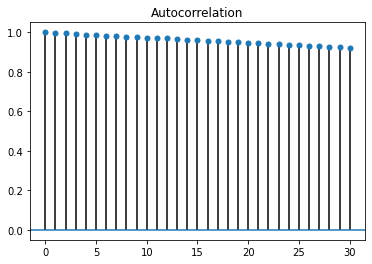

In [ ]:
pm.plot_acf(x_train[:896])

In [ ]:
from pmdarima.arima.stationarity import ADFTest

adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(x_train[:896])
print(p_val, should_diff)

0.9143123035619172 True


In [ ]:
from pmdarima.arima.utils import ndiffs

n_adf = ndiffs(x_train[:896], test='adf')
n_kpss = ndiffs(x_train[:896], test='kpss')
n_pp = ndiffs(x_train[:896], test='pp')

print(f'n_adf = {n_adf} n_kpss = {n_kpss} n_pp = {n_pp}')

n_adf = 1 n_kpss = 1 n_pp = 1


/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:222: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


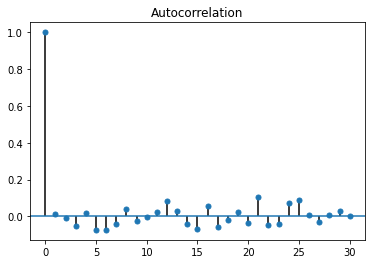

In [ ]:
from pmdarima.utils import c, diff

pm.plot_acf(diff(x_train[:896], lag=1, differences=1))

## Testes Regressão

## Regressão

In [12]:
class MySplit:

  def __init__(self, window_size, test_size):
    self.window_size = window_size
    self.test_size   = test_size 

  def split(self, X, y, groups):
    x_len = len(X)
    yield (list(range(0, x_len - self.window_size - self.test_size)),
           list(range(x_len - self.window_size - self.test_size, x_len - self.window_size)))



In [ ]:
# best_w_size = 2
# model = Ridge(alpha=0.0010126246213543052)

# tscv = MySplit(best_w_size, 100)

# rmse = test_model_rmse(model, x_train, tscv, best_w_size)

# print(-rmse)

# model.fit()

# best_rmse = model, data, split, best_w_size



In [20]:
best_w_size = 1
model =  PreviousTimesConstantRegressor(k=1.0003150236004175)


db_concat = db.to_numpy().flatten()

tscv = MySplit(best_w_size, 100)

rmse = test_model_rmse(model, db_concat, tscv, best_w_size)

print(-rmse)

1
43.852745031678815


In [24]:
from sklearn.metrics import mean_squared_error
score_rmse = lambda y_true, y_pred : mean_squared_error(y_true, y_pred, squared=False)

model.fit(x_train, None)

new_x_test = np.insert(x_test, 0, x_train[-1])

y_pred = model.predict(new_x_test)

rmse = score_rmse(x_test, y_pred[:-1])
print(rmse)

43.846886993100505


In [29]:
df = pd.DataFrame(data=np.array([x_test, y_pred[:-1]]).T, columns=['x_test', 'y_pred'])

df.to_csv(r'/content/drive/Shareddrives/MO432/pred_regressao.csv', index = False, header=True)

## Acurácia

In [39]:
from sklearn.metrics import accuracy_score

best_w_size = 1
model = SVC(kernel='rbf', C=12.189703398672739, gamma=0.6140621346569428, max_iter=100)
# model = Always1Classifier()

y_train = get_y_classification(x_train)

model.fit(x_train.copy().reshape(-1,1), y_train)

new_x_test = np.insert(x_test, 0, x_train[-1]).reshape(-1,1)
y_test = get_y_classification(new_x_test)

y_pred = model.predict(new_x_test)

score_accuracy = lambda y_true, y_pred : accuracy_score(y_true, y_pred)


acc = score_accuracy(y_test[1:], y_pred[:-1])

print(acc)

df = pd.DataFrame(data=np.array([y_test[1:], y_pred[:-1]]).T, columns=['y_test', 'y_pred'])

df.to_csv(r'/content/drive/Shareddrives/MO432/pred_classificacao.csv', index = False, header=True)



0.58
